In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import pandas as pd
import os
import re
import random
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import os
import pandas as pd
from skimage import io

In [3]:
data_dir="/content/drive/MyDrive/WILDLIFE_CV/animal_data/animal_data"

categories=os.listdir(data_dir)
print(categories)

['Dog', 'Elephant', 'Panda', 'Lion', 'Zebra', 'Horse', 'Giraffe', 'Tiger', 'Kangaroo', 'Dolphin', 'Cat', 'Deer', 'Bird', 'Bear', 'Cow']


In [4]:
animal_list=[]

def assign_label(image_path):
    species=image_path.split('/')[-2]
    if species=="Dog":
        return "Dog"
    elif species=="Elephant":
        return "Elephant"
    elif species=="Panda":
        return "Panda"
    elif species=="Lion":
        return "Lion"
    elif species=="Zebra":
        return "Zebra"
    elif species=="Horse":
        return "Horse"
    elif species=="Giraffe":
        return "Giraffe"
    elif species=="Tiger":
        return "Tiger"
    elif species=="Kangaroo":
        return "Kangaroo"
    elif species=="Dolphin":
        return "Dolphin"
    elif species=="Cat":
        return "Cat"
    elif species=="Deer":
        return "Deer"
    elif species=="Bird":
        return "Bird"
    elif species=="Bear":
        return "Bear"
    elif species=="Cow":
        return "Cow"
    else:
        return "Unknown"

for category in categories:
    category_path=os.path.join(data_dir,category)
    for img in os.listdir(category_path):
        img_path = os.path.join(category_path, img)
        animal_list.append((img_path, category))
df = pd.DataFrame(animal_list, columns=['image_path', 'label'])

label_encoder=LabelEncoder()

df['encoded_labels'] = label_encoder.fit_transform(df['label'])

In [5]:
df.sample(10)

,image_path,label,encoded_labels
262,/content/drive/MyDrive/WILDLIFE_CV/animal_data...,Panda,12
302,/content/drive/MyDrive/WILDLIFE_CV/animal_data...,Panda,12
113,/content/drive/MyDrive/WILDLIFE_CV/animal_data...,Dog,5
199,/content/drive/MyDrive/WILDLIFE_CV/animal_data...,Elephant,7
944,/content/drive/MyDrive/WILDLIFE_CV/animal_data...,Tiger,13
1688,/content/drive/MyDrive/WILDLIFE_CV/animal_data...,Bear,0
1828,/content/drive/MyDrive/WILDLIFE_CV/animal_data...,Cow,3
1004,/content/drive/MyDrive/WILDLIFE_CV/animal_data...,Tiger,13
615,/content/drive/MyDrive/WILDLIFE_CV/animal_data...,Zebra,14
20,/content/drive/MyDrive/WILDLIFE_CV/animal_data...,Dog,5


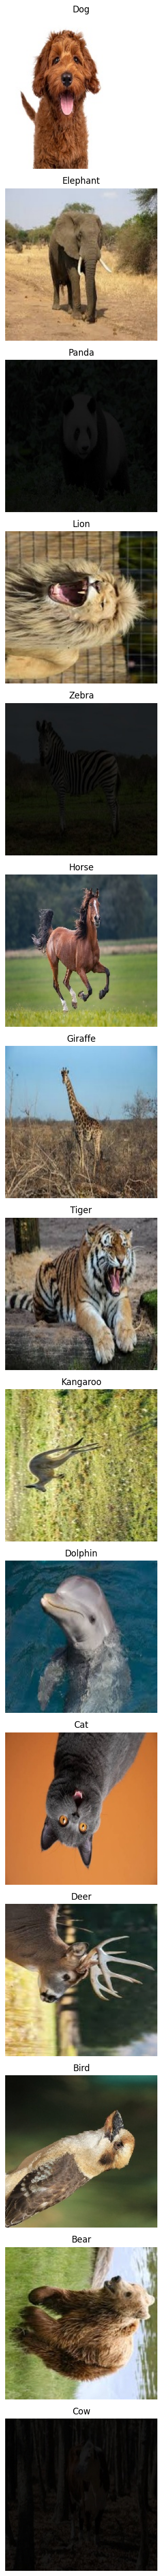

In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(img_path):
    img=load_img(img_path, target_size=(224,224))
    img_array=img_to_array(img)/255.0
    return img_array

def visualize_img(df,num_images=1):
    unique_labels=df['label'].unique()

    plt.figure(figsize=(50,50))

    for i, label in enumerate(unique_labels):

        label_images=df[df['label']==label].sample(n=min(num_images,len(df[df['label']==label])),random_state=8,replace=False)

        for j in range(len(label_images)):
            plt.subplot(len(unique_labels), num_images, i * num_images+ j + 1)
            img_path = label_images['image_path'].iloc[j]
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.axis('off')  # Turn off axis labels
            plt.title(label)  # Set title as the label name
    plt.tight_layout()

visualize_img(df)

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


img_width , img_height=224,224
batch_size=32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split into training and validation
)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical', # Use 'categorical' for multi-class classification
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 1556 validated image filenames belonging to 15 classes.
Found 388 validated image filenames belonging to 15 classes.


In [9]:
base_model=VGG16(weights='imagenet',include_top=False,input_shape=(img_width, img_height,3))

for layer in base_model.layers:
    layer.trainable=False

In [10]:
x=Flatten()(base_model.output)
x=Dense(256,activation='relu')(x)
x=Dropout(0.5)(x)

num_classes=len(train_generator.class_indices)
output_layer = Dense(num_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output_layer)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
#from tensorflow.keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Calculate steps_per_epoch and validation_steps
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

# Fit the model with calculated steps
model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 892ms/step - accuracy: 0.1350 - loss: 3.4527 - val_accuracy: 0.0000e+00 - val_loss: 4.3459
Epoch 2/30
 1/48 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.1875 - loss: 2.2304

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.1875 - loss: 2.2304 - val_accuracy: 0.0000e+00 - val_loss: 4.1617
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 863ms/step - accuracy: 0.2738 - loss: 2.1697 - val_accuracy: 0.0000e+00 - val_loss: 4.4123
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.2500 - loss: 2.1129 - val_accuracy: 0.0000e+00 - val_loss: 4.4198
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 644ms/step - accuracy: 0.3267 - loss: 2.0017 - val_accuracy: 0.0000e+00 - val_loss: 5.5360
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.4375 - loss: 1.8786 - val_accuracy: 0.0000e+00 - val_loss: 5.4672
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 642ms/step - accuracy: 0.4130 - loss: 1.8124 - val_accuracy: 0.0000e+00 - val_loss: 6.0540
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.3750 - loss: 2.2030 - val_accuracy: 0.0000e+00 - val_loss: 5.7418
Epoch 9/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 861ms/step - accuracy: 0.3887 - loss: 1.79

In [19]:
loss,accuracy=model.evaluate(validation_generator)
print(f"VAl loss: {loss}")
print(f"Val Accuracy: {accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.0000e+00 - loss: 11.0549
VAl loss: 9.9840669631958
Val Accuracy: 0.0


In [ ]:

num_samples=5
sample_indices=np.random.choice(validation_generator.samples, num_samples, replace=False)


for i in sample_indices:
    img,label=validation_generator[i//validation_generator.batch_size][0][i%validation_generator.batch_size, validation_generator],[1//validation_generator.batch_size][1][1%validation_generator.batch_size]

    print(f"True Label:{label}")

    img=np.extend_dims(img,axis=0)
    prediction=model.predict(img)
    predicted_class=np.argmax(prediction)

    predicted_label = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(predicted_class)]

    # Print the predicted label
    print(f"Predicted Label: {predicted_label}\n")

